In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brenth
import scipy.integrate as integrate

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
pi=np.pi
a=0.75
b=np.rint((1.+1.5*pi)/a) #no siempre es impar
b=b+np.mod(b+1,2)

In [3]:
def z(x, n): return (a/b)**n*np.cos(b**n*pi*x)
def w(x, n): return a**n*np.sin(b**n*pi*x)
def dw(x, n): return (a*b)**n*np.cos(b**n*pi*x)

In [4]:
def Z(x,p):
    suma=0
    for n in range(p+1):
        suma+= z(x, n)
    return -suma/pi
def W(x,p):
    suma=0
    for n in range(p+1):
        suma+= w(x, n)
    return suma
def dW(x,p):
    suma=0
    for n in range(p+1):
        suma+= dw(x, n)
    return pi*suma

In [5]:
def U(x): return 0.5*x**2+alpha*Z(x,p)
def dU(x): return x+alpha*W(x,p)
def ddU(x): return 1+alpha*dW(x,p)

def T(x): return 1-(dU(x)/g1)**2
def dT(x): return -2*dU(x)*ddU(x)/g1**2

def Ueff(x): return U(x)+T(x)/g2
def dUeff(x): return dU(x)+ dT(x)/g2
def ddUeff(x): return ddU(x)*(1-2*ddU(x)/(g2*g1**2))

def integrand(x): return dUeff(x)/T(x)
def f1(x): return dU(x)-g1
def f2(x): return dU(x)+g1

In [6]:
def root(F, x1, x2, div, it):
    X=np.linspace(x1,x2, div)
    roots=np.array([])
    for i in range(div-1):
        if F(X[i])*F(X[i+1])<=0:
            p1=X[i]
            p2=X[i+1]
            r=brenth(F, p1, p2, maxiter=it)
            roots=np.append(roots, r)
    return roots
def integral2(F, X):
    l=len(X)
    Func=np.zeros(l)
    id0=int(0.5*l)
    xmin=X[id0]
    Func[id0]=0
    for i in range(1,l):
        if i<=id0:
            x0 = X[id0-i+1]
            x1 = X[id0-i]
            Func[id0-i]=integrate.quad(F, x0, x1)[0]
            Func[id0-i]=Func[id0-i]+Func[id0-i+1]
        else:
            x0 = X[i-1]
            x1 = X[i]
            Func[i]=integrate.quad(F, x0, x1)[0]
            Func[i]=Func[i]+Func[i-1]
    return Func
def evol(x, h):
    e=np.random.normal(0, 1)
    y=x-h*dU(x)/g1+np.sqrt(2*T(x)*h/(g1*g2))*e
    return y

In [7]:
p = 3
Wbound= (1.-a**(p+1))/(1.-a)
Alpha = np.array([0.1, 0.9])
print(Wbound*Alpha)

[ 0.2734375  2.4609375]


## Finding g1c

In [8]:
G1c = np.array([])
for i in range(2):
    alpha = Alpha[i]
    g1 = 0.25  #finding minimum value of interest for g1
    dg1 = 1e-6
    for i in range(75):    
        a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
        a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
        positive = np.concatenate([a1[a1>0], a2[a2>0]])
        negative = np.concatenate([a1[a1<0], a2[a2<0]])
        xmin = max(0.999*negative)
        xmax = min(0.999*positive)
        H = root(dU, xmin, xmax, 5000, 100)
        if len(H) == 1: 
            g1 = g1 + dg1
        else:
            g1 = g1 - dg1
    g1c = g1
    G1c = np.append(G1c, g1c)
G1c

array([ 0.249925,  0.250075])

In [9]:
G1min = np.array([])
for i in range(2):
    alpha = Alpha[i]
    g1c = G1c[i]
    g1 = g1c  #finding minimum value of interest for g1
    dg1 = 0.5
    for i in range(75):    
        a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
        a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
        positive = np.concatenate([a1[a1>0], a2[a2>0]])
        negative = np.concatenate([a1[a1<0], a2[a2<0]])
        xmin = max(0.999*negative)
        xmax = min(0.999*positive)
        x = np.linspace(xmin,xmax, 10000)
        H = max(U(x))
        if H < 0: 
            g1 = g1 + dg1
        else:
            dg1 = 0.75*dg1
            g1 = g1 - dg1
    g1min = g1
    G1min = np.append(G1min, g1min)
G1min

array([ 0.4055041 ,  2.41710244])

## Potencial Jerárquico

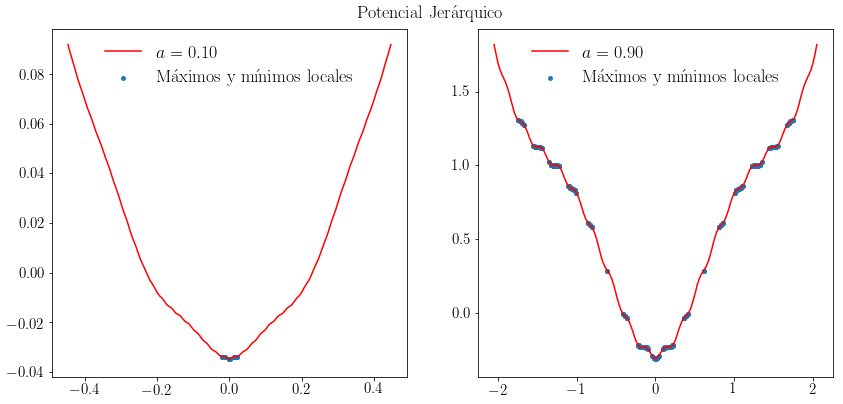

In [10]:
plt.figure(figsize=(14, 6))
for i in range(2):
    alpha = Alpha[i]
    g1min=G1min[i]
    g1=1.5*g1min
    a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
    a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
    positive = np.concatenate([a2[a2>0], a1[a1>0]])
    negative = np.concatenate([a2[a2<0], a1[a1<0]])
    xmin = max(negative)
    xmax = min(positive)
    x = np.linspace(xmin,xmax, 10000)
    r = root(dU, xmin, xmax, 100000, 100)
    
    plt.subplot(1, 2, i+1)
    plt.plot(x, U(x), color='red', label = r'$a = %.2f$'%alpha)
    plt.scatter(r, U(r), s=15, label=r'M\'aximos y m\'inimos locales')
    plt.legend(loc='best', frameon=0, fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
plt.subplots_adjust(top=0.93)
plt.suptitle(r'Potencial Jer\'arquico', fontsize=18)
plt.savefig('UW.png', bbox_inches='tight')
plt.show()
plt.close()

## Below and above g1min

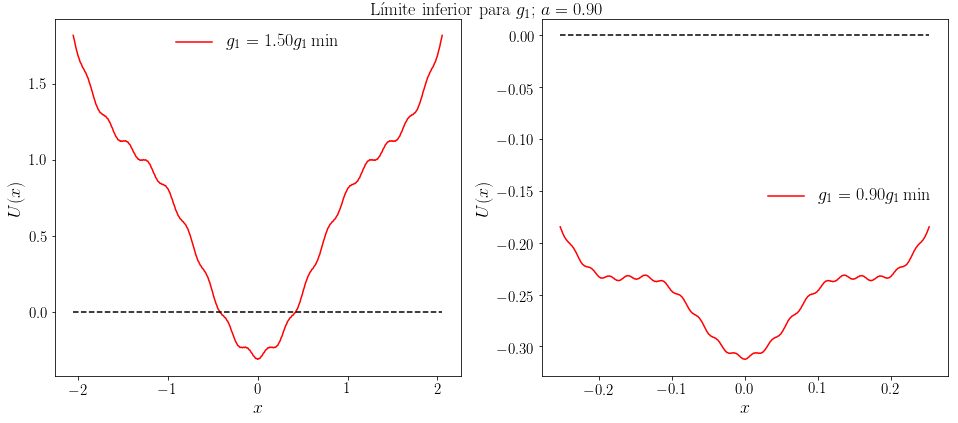

In [11]:
alpha = Alpha[1]
g1min = G1min[1]
#plt.figure(figsize=(14, 12))
plt.figure(figsize=(16, 6))
vector= np.array([1.5*g1min,0.9*g1min])
i=1
for g1 in vector:
    a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
    a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
    positive = np.concatenate([a2[a2>0], a1[a1>0]])
    negative = np.concatenate([a2[a2<0], a1[a1<0]])
    xmin = max(negative)
    xmax = min(positive)
    x = np.linspace(xmin,xmax, 10000)
    r = root(dT, xmin,xmax, 50000, 100)
    x = np.concatenate([x,r])
    x = np.sort(x)
    
    times=g1/g1min
    #plt.subplot(2,2,i)
    plt.subplot(1,2,i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.plot(x, U(x), color='red', label = r'$g_1 = %.2f g_1\min$'%times)
    plt.xlabel(r'$x$', fontsize = 18)
    plt.ylabel(r'$U(x)$', fontsize=18)
    plt.plot([xmin,xmax], [0,0], 'k--')
    plt.legend(loc='best', frameon=0, fontsize=18)
    i=i+1
    #plt.subplot(2,2,i+1)
    #plt.xticks(fontsize=15)
    #plt.yticks(fontsize=15)
    #plt.plot(x, T(x), color='red', lw = 0.5)
    #plt.xlabel(r'$x$', fontsize = 18)
    #plt.ylabel(r'$T(x)$', fontsize=18)
    #i=2*i+1
plt.subplots_adjust(top=0.95)
plt.suptitle(r'L\'imite inferior para $g_1$; $a=%.2f$'%alpha, fontsize=18)
plt.savefig('g1minW.png', bbox_inches='tight')
plt.show()
plt.close()

## Domain as function of g1

In [13]:
alpha = Alpha[1]
g1c = G1c[1]
g1min = G1min[1]

G1 = np.linspace(100, g1c, 1000)
xl = np.array([])
xu = np.array([])
interval = np.array([])

for g1 in G1:
    a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
    a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
    positive = np.concatenate([a1[a1>0], a2[a2>0]])
    negative = np.concatenate([a1[a1<0], a2[a2<0]])

    xmin = max(negative)
    xmax = min(positive)
    
    xl = np.append(xl, xmin)
    xu = np.append(xu, xmax)
    interval = np.append(interval, np.absolute(xmax-xmin))

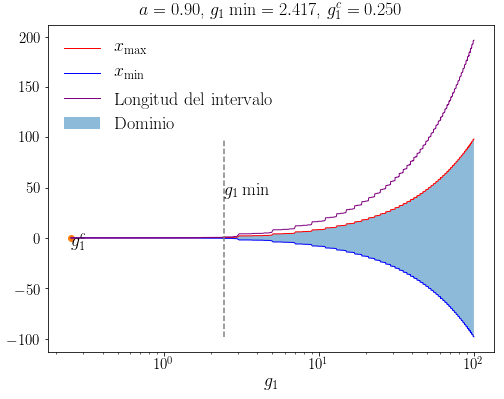

In [14]:
plt.figure(figsize=(8, 6))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.semilogx(G1, xu, label=r'$x_{\max}$', color='red', lw=1)
plt.semilogx(G1, xl, label=r'$x_{\min}$', color='blue', lw=1)
plt.fill_between(G1, xu, xl, alpha=0.5, label=r'Dominio')
plt.semilogx(G1, interval, label= r'Longitud del intervalo', color='purple', lw=1)
plt.plot([g1min, g1min],[min(xl), max(xu)], ls='--', color='grey')

plt.scatter(g1c, 0)
plt.text(g1c,-12, r'$g_1^c$', fontsize=18)
plt.text(g1min,40, r'$g_1\min $', fontsize=18)
plt.xlabel(r'$g_1$', fontsize=18)
plt.legend(loc='best', frameon=0, fontsize=18)
plt.title(r'$a=%.2f$, $g_1\min = %.3f$, $g_1^c = %.3f$'%(alpha, g1min, g1c), fontsize=18)

plt.savefig('g1cW.png', bbox_inches='tight')
plt.show()
plt.close()

## Temperatura efectiva

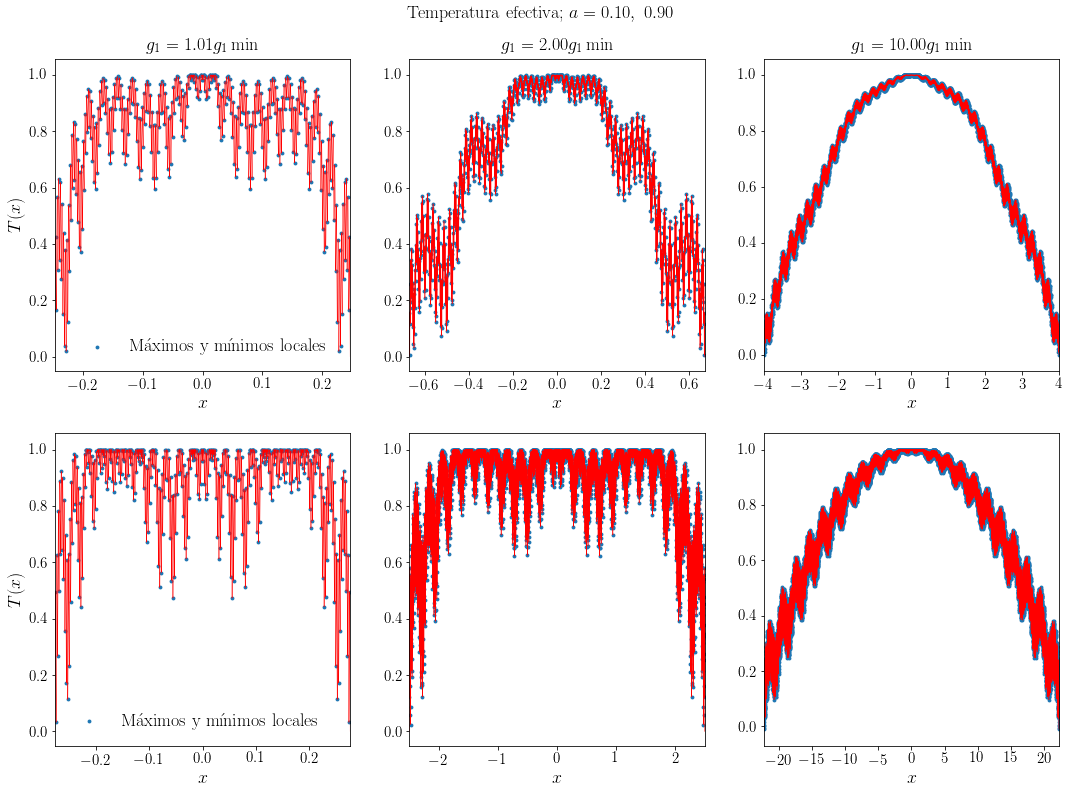

In [15]:
plt.figure(figsize=(18, 12))
for j in range(2):
    alpha = Alpha[j]
    g1min = G1min[j]
    g1c = G1c[j]
    G1=np.array([1.01, 2., 10.])
    
    for i in range(3):
        g1=G1[i]*g1min
        a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
        a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
        positive = np.concatenate([a1[a1>0], a2[a2>0]])
        negative = np.concatenate([a1[a1<0], a2[a2<0]])
        xmin = max(negative)
        xmax = min(positive)
        x = np.linspace(xmin,xmax, 10000)

        rT = root(dT, xmin, xmax, 30000, 300)
        x=np.concatenate([x,rT])
        x=np.sort(x)

        plt.subplot(2,3,i+j*3+1)
        plt.plot(x, T(x), color='red', lw= 0.5)
        if (i==0 & j==0): plt.scatter(rT, T(rT), lw= 0, s= 15, label=r'M\'aximos y m\'inimos locales')
        else: plt.scatter(rT, T(rT), lw= 0, s= 15)

        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlim([xmin,xmax])
        if j==0: plt.title(r'$g_1 = %.2f g_1\min $'%G1[i], fontsize=18)
        plt.xlabel('$x$', fontsize=18)
        if i==0: plt.ylabel('$T(x)$', fontsize=18)
        plt.legend(loc='best', frameon=0, fontsize=18)
        
plt.subplots_adjust(top=0.92)
plt.suptitle('Temperatura efectiva; $a = %.2f,\ %.2f$'%(Alpha[0], Alpha[1]), fontsize=18)
plt.savefig('TW.png', bbox_inches='tight')
plt.show()
plt.close()

## Transitions by g2 in Ueff

In [12]:
alpha=Alpha[1]
g1min=G1min[1]
g1c=G1c[1]
times=1.01
g1=times*g1min

a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
positive = np.concatenate([a2[a2>0], a1[a1>0]])
negative = np.concatenate([a2[a2<0], a1[a1<0]])
xmin = max(negative)
xmax = min(positive)
x = np.linspace(xmin,xmax, 10000)

r = root(dU, xmin, xmax, 50000, 500)
g2= 1e-7
D = ddU(r)
r = r[ D > 0] 
D = D[ D > 0]
sort = np.argsort(D)
r = r[sort]

g2c = np.array([])
for idx in range(len(r)):
    value = -1
    counter = 0
    dg2 = 1e-3
    while value < 0 :
        g2 = g2 + dg2
        value = ddUeff(r[idx])
        counter = counter + 1
    g2c = np.append(g2c, g2)

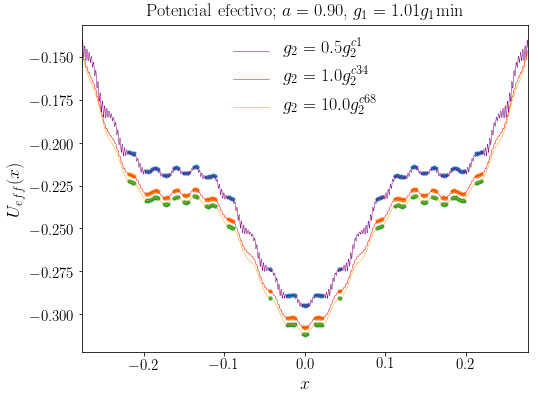

In [13]:
G2 = np.array([0.5*g2c[0], g2c[int(0.5*len(g2c))], 10*g2c[-1]])
idx = np.array([1, int(0.5*len(g2c))+1, len(g2c)+1 ], dtype=int)
legend = np.array([0.5, 1, 10])
color=['purple', 'red', 'orange']

r = root(dU, xmin, xmax, 50000, 300)
x=np.linspace(0.999*xmin,0.999*xmax, 2000)
x = np.concatenate([r,x])
x = np.sort(x)

plt.figure(figsize=(8, 6))
for i in range(3):
    g2 = G2[i]
    plt.plot(x, Ueff(x), color=color[i], alpha= 1, label=r'$g_2 = %.1f g_2^{c%d}$'%(legend[i],idx[i]), lw =0.5)
    plt.scatter(r, Ueff(r), lw=0, s=15)
    
    plt.xlim([xmin,xmax])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('$x$', fontsize=18)
    plt.ylabel(r'$U_{eff}(x)$', fontsize=18)
    plt.legend(frameon=0, loc='best', fontsize=18)
    plt.title('Potencial efectivo; $a=%.2f$,  $g_1 = %.2f g_1$min'%(alpha, times), fontsize=18)
    
plt.savefig('UeffW.png', bbox_inches='tight')
plt.show()
plt.close()

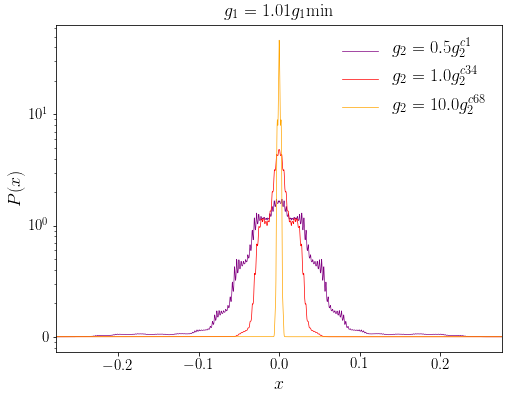

In [25]:
plt.figure(figsize=(8, 6))
for j in range(len(G2)):
    g2=G2[j]    
    inte=integral2(integrand, x)
    inte=-g2*inte
    prob=np.exp(inte)
    prob[prob==np.nan]=0
    Part=np.trapz(prob, x)
    plt.plot(x, prob/Part+1, color=color[j], alpha = 1, label = r'$g_2 = %.1f g_2^{c%d}$'%(legend[j],idx[j]), lw = 0.7)    

plt.xlim([xmin,xmax])
plt.yscale('log')
plt.yticks([1, 10, 100],[r'$0$', r'$10^{0}$', r'$10^{1}$'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel('$P(x)$', fontsize=18)
plt.title(r'$g_1=%.2f g_1$min'%times, fontsize=18)
plt.legend(loc='best', frameon=0, fontsize=18)

plt.savefig('PW.png', bbox_inches='tight')
plt.show()
plt.close()

## Varios panaeles: Potencial efectivo

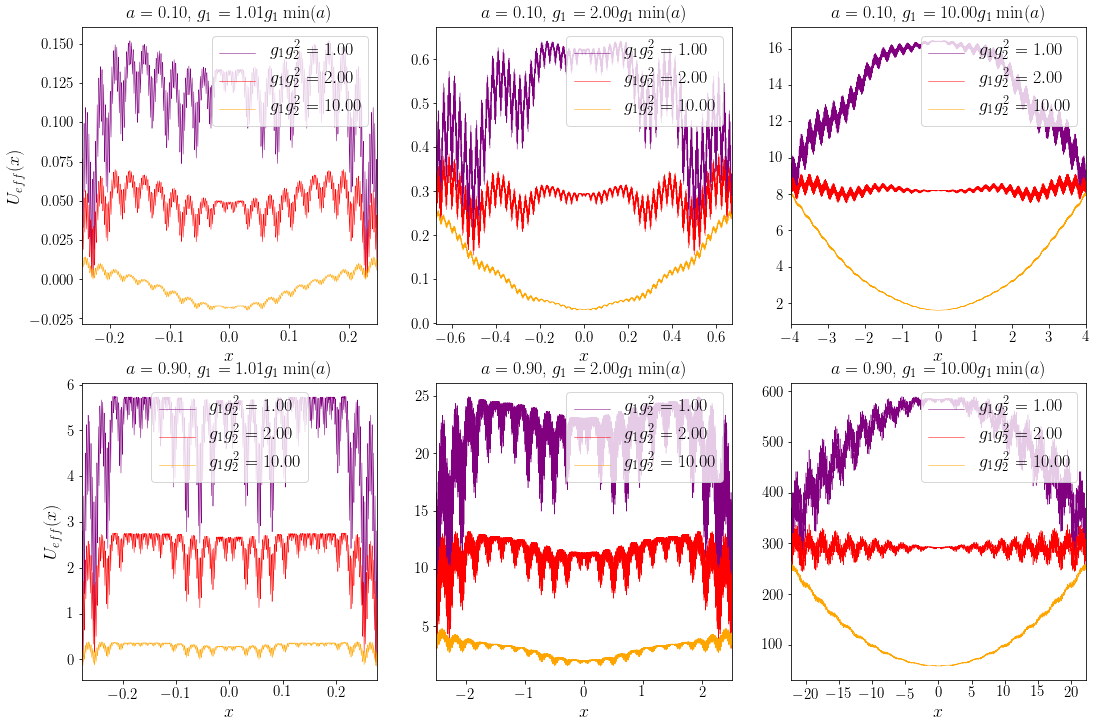

In [38]:
G1 = np.array([1.01, 2.0, 10.])
goal = np.array([1., 2., 10.])
color=['purple', 'red', 'orange']

plt.figure(figsize=(18, 12))
for i in range(2):
    alpha=Alpha[i]
    g1min=G1min[i]
    g1c=G1c[i]
    for j in range(3):
        times=G1[j]
        g1=times*g1min
        a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
        a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
        positive = np.concatenate([a2[a2>0], a1[a1>0]])
        negative = np.concatenate([a2[a2<0], a1[a1<0]])
        xmin = max(negative)
        xmax = min(positive)
        rU = root(dU, xmin,xmax, 5000, 500)
        rT = root(dT, xmin,xmax, 5000, 500)
        x = np.linspace(xmin,xmax, 500)
        x = np.concatenate((x,rU,rT))
        x = np.sort(x)
        plt.subplot(2, 3, 3*i+j+1)
        for k in range(3):
            g2 = goal[k]/g1**2
            plt.plot(x, Ueff(x), color=color[k],label=r'$g_1 g_2^2=%.2f$'%goal[k], alpha= 1, lw =0.5)
        plt.xlim([xmin,xmax])
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlabel('$x$', fontsize=18)
        plt.title(r'$a=%.2f$, $g_1 =%.2f g_1\min(a)$'%(alpha, times), fontsize=18)
        if j==0: plt.ylabel(r'$U_{eff}(x)$', fontsize=18)
        plt.legend(frameon=1, loc='best', fontsize=18)
plt.savefig('UeffW2.png', bbox_inches='tight')
plt.show()
plt.close()

## Varios Paneles: Probability

C:\Users\hp\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)
C:\Users\hp\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


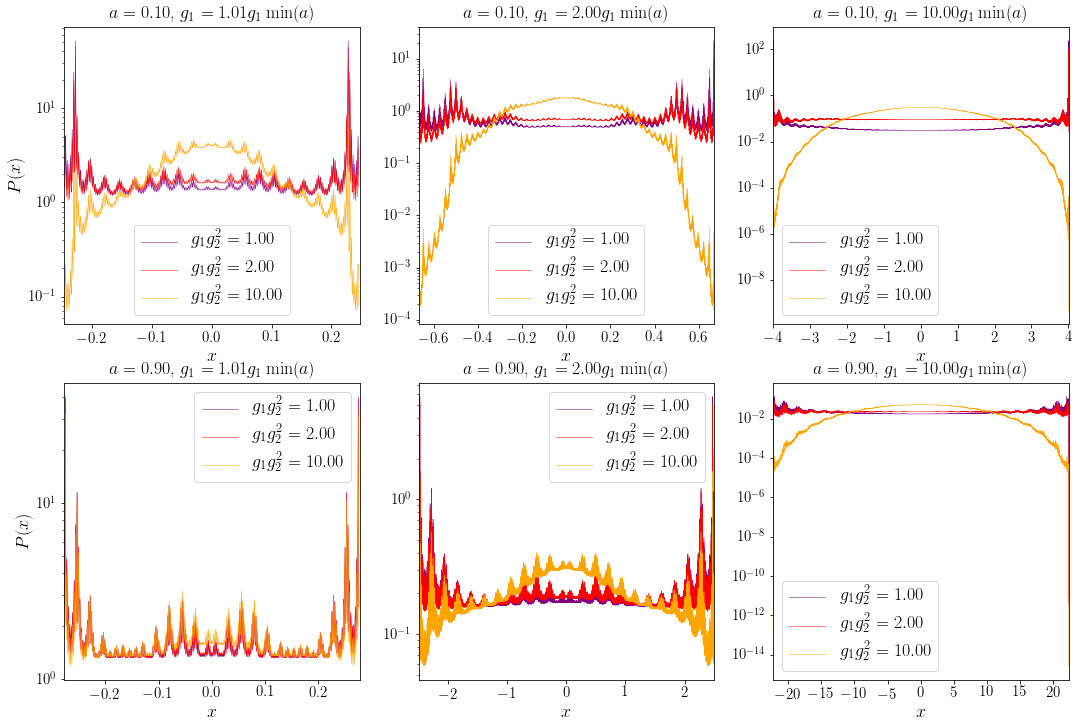

In [39]:
G1 = np.array([1.01, 2., 10.])
goal = np.array([1., 2., 10.])
color=['purple', 'red', 'orange']

plt.figure(figsize=(18, 12))
for i in range(2):
    alpha=Alpha[i]
    g1min=G1min[i]
    g1c=G1c[i]
    for j in range(3):
        times=G1[j]
        g1=times*g1min
        a1 = root(f1, g1-alpha*Wbound, g1+alpha*Wbound, 5000, 100)
        a2 = root(f2, -g1-alpha*Wbound,-g1+alpha*Wbound , 5000, 100)
        positive = np.concatenate([a2[a2>0], a1[a1>0]])
        negative = np.concatenate([a2[a2<0], a1[a1<0]])
        xmin = max(negative)
        xmax = min(positive)
        
        rU = root(dU, xmin,xmax, 5000, 500)
        rT = root(dT, xmin,xmax, 5000, 500)
        x = np.linspace(.99*xmin,.99*xmax, 100)
        x = np.concatenate((x,rU,rT))
        x = np.sort(x)
        plt.subplot(2, 3, 3*i+j+1)
        for k in range(3):
            g2 = goal[k]/g1**2
            inte=integral2(integrand, x)
            inte=-g2*inte
            prob=np.exp(inte)
            prob[prob==np.nan]=0
            Part=np.trapz(prob, x)
            plt.plot(x, prob/Part, color=color[k],label=r'$g_1 g_2^2=%.2f$'%goal[k], alpha= 1, lw =0.5)
        plt.xlim([xmin,xmax])
        plt.yscale('log')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlabel('$x$', fontsize=18)
        plt.title(r'$a=%.2f$, $g_1 =%.2f g_1\min(a)$'%(alpha, times), fontsize=18)
        if j==0: plt.ylabel(r'$P(x)$', fontsize=18)
        plt.legend(frameon=1, loc='best', fontsize=18)
        
plt.savefig('PW2.png', bbox_inches='tight')
plt.show()
plt.close()